<a href="https://colab.research.google.com/github/Tejaswi37/2303A51944-Batch-27-/blob/main/RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
from tqdm import trange, tqdm



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
csv_path ="/content/synthetic_personal_finance_dataset (1) (1).csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}. Update path variable.")

df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
display_cols = ["user_id", "monthly_income_usd", "monthly_expenses_usd", "savings_usd", "debt_to_income_ratio", "savings_to_income_ratio"]
print(df[display_cols].head())


Loaded rows: 32424
  user_id  monthly_income_usd  monthly_expenses_usd  savings_usd  \
0  U00001             3531.69               1182.59    367655.03   
1  U00002             3531.73               2367.99    260869.10   
2  U00003             2799.49               1003.91    230921.21   
3  U00004             5894.88               4440.12    304815.51   
4  U00005             5128.93               4137.61    461509.48   

   debt_to_income_ratio  savings_to_income_ratio  
0                  0.00                     8.68  
1                  1.40                     6.16  
2                  0.00                     6.87  
3                  0.84                     4.31  
4                  0.00                     7.50  


In [ ]:
features = ["monthly_income_usd", "monthly_expenses_usd", "savings_usd",
            "debt_to_income_ratio", "savings_to_income_ratio"]

data = df[features].copy()



In [ ]:
missing_frac = data.isna().mean()
print("Missing fraction per feature:\n", missing_frac)


Missing fraction per feature:
 monthly_income_usd         0.0
monthly_expenses_usd       0.0
savings_usd                0.0
debt_to_income_ratio       0.0
savings_to_income_ratio    0.0
dtype: float64


In [ ]:
data = data.dropna(thresh=len(features)-2).reset_index(drop=True)

In [ ]:
for col in features:
    if data[col].isna().any():
        data[col] = data[col].fillna(data[col].median())

In [ ]:
def remove_outliers_iqr(df_in, cols, k=1.5):
    df_out = df_in.copy()
    mask = pd.Series(True, index=df_out.index)
    for col in cols:
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask &= df_out[col].between(lower, upper, inclusive="both")
    return df_out[mask].reset_index(drop=True)

data_no_out = remove_outliers_iqr(data, features, k=3.0)  # be conservative (k=3)
print(f"Rows before outlier removal: {len(data)}, after: {len(data_no_out)}")


Rows before outlier removal: 32424, after: 29732


In [ ]:
data_no_out["expenses_to_income_ratio"] = data_no_out["monthly_expenses_usd"] / (data_no_out["monthly_income_usd"].replace(0, np.nan))
data_no_out["expenses_to_income_ratio"] = data_no_out["expenses_to_income_ratio"].fillna(data_no_out["expenses_to_income_ratio"].median())


In [ ]:
to_scale = ["monthly_income_usd", "monthly_expenses_usd", "savings_usd",
            "debt_to_income_ratio", "savings_to_income_ratio", "expenses_to_income_ratio"]
scaler = RobustScaler()  # robust to outliers
X = scaler.fit_transform(data_no_out[to_scale])



In [ ]:
X_df = pd.DataFrame(X, columns=to_scale)


In [ ]:
results = {}

In [ ]:
def run_kmeans_range(X, k_min=2, k_max=8):
    best = None
    scores = {}
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        scores[k] = {"estimator": km, "labels": labels, "silhouette": sil, "db": db, "ch": ch}
        print(f"K={k} Silhouette={sil:.4f} DB={db:.4f} CH={ch:.1f}")
        if best is None or sil > best[0]:
            best = (sil, k)
    return scores, best

k_scores, best_k = run_kmeans_range(X, 2, 8)
best_k_value = best_k[1]
print("Best K by silhouette:", best_k)

K=2 Silhouette=0.4915 DB=0.8851 CH=20838.4
K=3 Silhouette=0.2987 DB=1.1689 CH=19144.8
K=4 Silhouette=0.2945 DB=1.1716 CH=16468.7
K=5 Silhouette=0.2663 DB=1.2011 CH=15482.5
K=6 Silhouette=0.2507 DB=1.1697 CH=14528.0
K=7 Silhouette=0.2330 DB=1.2123 CH=13435.8
K=8 Silhouette=0.2368 DB=1.1763 CH=12597.1
Best K by silhouette: (np.float64(0.4914760627453524), 2)


In [ ]:
best_km = k_scores[best_k_value]["estimator"]
km_labels = k_scores[best_k_value]["labels"]
results["kmeans"] = {"labels": km_labels, "model": best_km, "metrics": k_scores[best_k_value]}


In [ ]:
agg = AgglomerativeClustering(n_clusters=best_k_value)
agg_labels = agg.fit_predict(X)
results["agg"] = {"labels": agg_labels, "model": agg}

print("Agglomerative silhouette:", silhouette_score(X, agg_labels))

Agglomerative silhouette: 0.5136741077539438


In [ ]:
for eps in [0.3, 0.5, 0.7, 1.0]:
    dbs = DBSCAN(eps=eps, min_samples=8)
    lab = dbs.fit_predict(X)
    n_clusters = len(set(lab)) - (1 if -1 in lab else 0)
    if n_clusters <= 1:
        sil = -1
    else:
        try:
            sil = silhouette_score(X, lab)
        except:
            sil = -1
    print(f"DBSCAN eps={eps} clusters={n_clusters} silhouette={sil:.4f}")
results["dbscan_example"] = {"eps": eps, "labels": lab}

# =========================
# 4) Cluster validation & profiling
# =========================
def profile_clusters(X_raw_df, labels, name="clusters"):
    dfp = X_raw_df.copy()
    dfp["cluster"] = labels
    prof = dfp.groupby("cluster").agg(["count","mean","median","std"])
    print(f"\nProfile: {name}\n", prof)
    return prof

km_profile = profile_clusters(data_no_out[to_scale], km_labels, "KMeans")

DBSCAN eps=0.3 clusters=71 silhouette=-0.4327
DBSCAN eps=0.5 clusters=2 silhouette=0.3976
DBSCAN eps=0.7 clusters=1 silhouette=-1.0000
DBSCAN eps=1.0 clusters=1 silhouette=-1.0000

Profile: KMeans
         monthly_income_usd                                     \
                     count         mean   median          std   
cluster                                                         
0                    24969  4198.654807  4183.78  1906.186083   
1                     4763  3948.594720  3871.73  1670.260125   

        monthly_expenses_usd                                    savings_usd  \
                       count         mean   median          std       count   
cluster                                                                       
0                      24969  2521.306511  2322.06  1396.909048       24969   
1                       4763  2374.460785  2194.97  1239.367779        4763   

                        ... debt_to_income_ratio            \
                  

In [ ]:
for key, val in results.items():
    if "labels" in val:
        labels = val["labels"]
        try:
            sil = silhouette_score(X, labels)
        except:
            sil = None
        try:
            db = davies_bouldin_score(X, labels)
        except:
            db = None
        try:
            ch = calinski_harabasz_score(X, labels)
        except:
            ch = None
        print(f"{key}: silhouette={sil}, db={db}, ch={ch}")

kmeans: silhouette=0.4914760627453524, db=0.885076711796571, ch=20838.36084245095
agg: silhouette=0.5136741077539438, db=0.7730545059120091, ch=17715.930667800647
dbscan_example: silhouette=0.5236242652430646, db=0.8283333530355534, ch=57.92648182858652


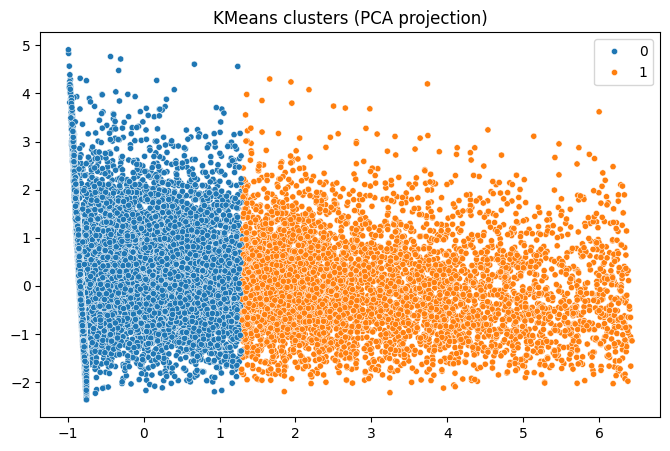

In [ ]:
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=km_labels, palette="tab10", legend="full", s=20)
plt.title("KMeans clusters (PCA projection)")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


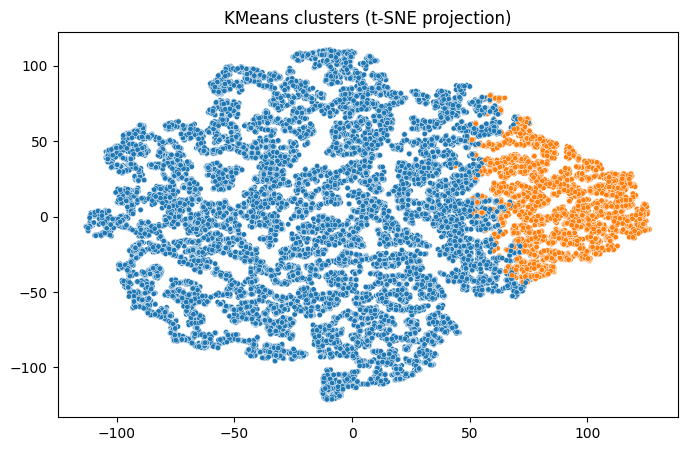

In [ ]:
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=km_labels, palette="tab10", legend=None, s=15)
plt.title("KMeans clusters (t-SNE projection)")
plt.show()

In [ ]:

  class FinanceEnv:
    def __init__(self, data_df, scaler, max_steps=6):
        """
        data_df: original (unscaled) DataFrame for individuals (selected features)
        scaler: fitted scaler to transform states into agent-ready state
        """
        self.raw = data_df.reset_index(drop=True)
        self.scaler = scaler
        self.max_steps = max_steps
        self.action_space = 4
        self.state_cols = to_scale  # names used earlier
        self.reset()

    def reset(self, idx=None):
       # pick random individual or specific index
        if idx is None:
            idx = np.random.randint(0, len(self.raw))
        self.idx = idx
        row = self.raw.loc[idx, self.state_cols].values.astype(float)
        self.orig = row.copy()
        # Internal state tracked as continuous raw (not scaled)
        self.state_raw = row.copy()
        self.step_count = 0
        return self._get_obs()

    def _get_obs(self):
        # produce scaled state vector (for NN input)
        scaled = self.scaler.transform(self.state_raw.reshape(1,-1))[0]
        return scaled.astype(np.float32)

    def step(self, action):
        """
        action: int 0..3
        Returns: next_state, reward, done, info
        """
        assert action in [0,1,2,3]
        prev_state = self.state_raw.copy()
        # small stochasticity
        noise = np.random.normal(0, 0.01, size=self.state_raw.shape)

        monthly_income = self.state_raw[0]
        monthly_expenses = self.state_raw[1]
        savings = self.state_raw[2]
        dti = self.state_raw[3]  # debt_to_income_ratio
        savings_to_income = self.state_raw[4]


Loaded rows: 32424
  user_id  monthly_income_usd  monthly_expenses_usd  savings_usd  \
0  U00001             3531.69               1182.59    367655.03   
1  U00002             3531.73               2367.99    260869.10   
2  U00003             2799.49               1003.91    230921.21   
3  U00004             5894.88               4440.12    304815.51   
4  U00005             5128.93               4137.61    461509.48   

   debt_to_income_ratio  savings_to_income_ratio  
0                  0.00                     8.68  
1                  1.40                     6.16  
2                  0.00                     6.87  
3                  0.84                     4.31  
4                  0.00                     7.50  
Missing fraction per feature:
 monthly_income_usd         0.0
monthly_expenses_usd       0.0
savings_usd                0.0
debt_to_income_ratio       0.0
savings_to_income_ratio    0.0
dtype: float64
Rows before outlier removal: 32424, after: 29732
K=2 Silhouette=0

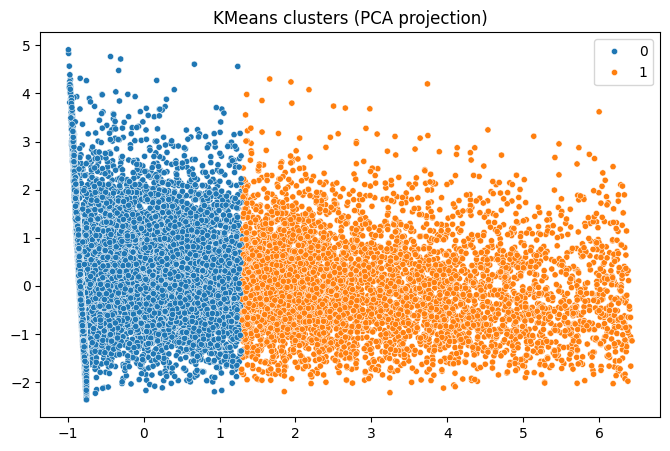

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


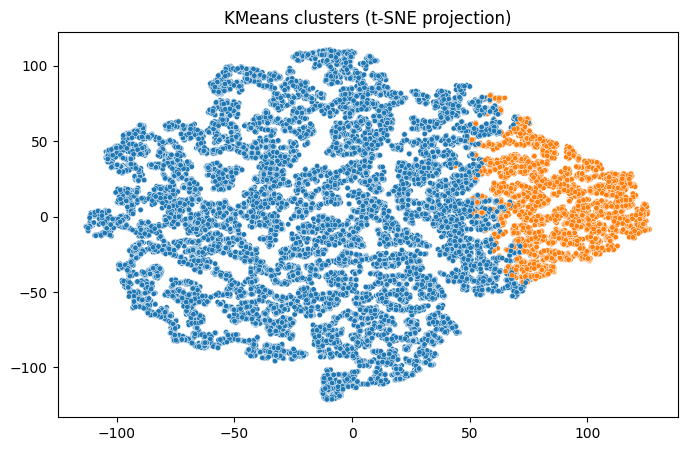

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

state shape: (6,) reward sample: -0.44127239821691866 done: False
Training DQN (demo, small episodes)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[DQN] Episode 50/200 avg_reward_last50=-1.655


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[DQN] Episode 100/200 avg_reward_last50=1.474


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[DQN] Episode 150/200 avg_reward_last50=0.112


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[DQN] Episode 200/200 avg_reward_last50=0.961
Training REINFORCE (demo)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[REINFORCE] Episode 100/300 avg_reward_last100=0.863


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[REINFORCE] Episode 200/300 avg_reward_last100=0.904


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/valida

[REINFORCE] Episode 300/300 avg_reward_last100=1.509


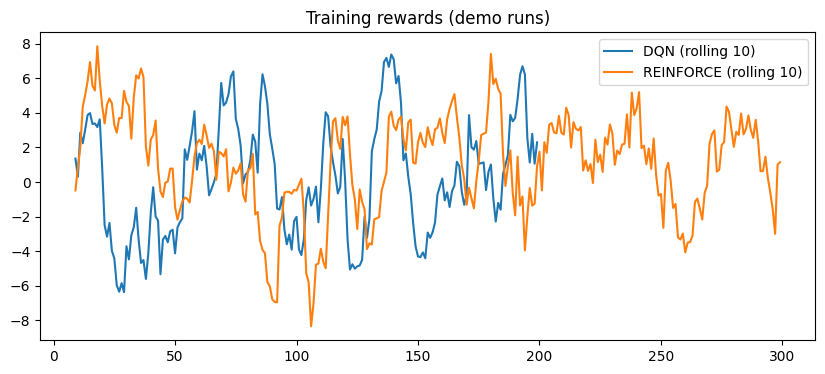


Cluster centroids (unscaled -> scaled -> feed to policy):
Cluster 0: DQN_action=0, PG_action=3, PG_probs=[0.20795602 0.24229153 0.21376954 0.33598286]
Cluster 1: DQN_action=3, PG_action=3, PG_probs=[0.11624416 0.21695527 0.09807052 0.56873   ]
Models saved: dqn_policy_demo.pth, pg_policy_demo.pth


In [61]:
# finance_clustering_and_rl.py
import os
import math
import random
import numpy as np
import pandas as pd
from tqdm import trange, tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for clustering and metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Torch for RL
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# =========================
# 1) Load dataset
# =========================
csv_path = "/content/synthetic_personal_finance_dataset (1) (1).csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}. Update path variable.")

df = pd.read_csv(csv_path)
print("Loaded rows:", len(df))
display_cols = ["user_id", "monthly_income_usd", "monthly_expenses_usd", "savings_usd", "debt_to_income_ratio", "savings_to_income_ratio"]
print(df[display_cols].head())

# =========================
# 2) Preprocessing
# =========================
# Select features for clustering as specified in problem statement
features = ["monthly_income_usd", "monthly_expenses_usd", "savings_usd",
            "debt_to_income_ratio", "savings_to_income_ratio"]

data = df[features].copy()

# Basic cleaning: drop rows missing many critical fields; impute small fraction
missing_frac = data.isna().mean()
print("Missing fraction per feature:\n", missing_frac)

# Drop rows missing >2 features
data = data.dropna(thresh=len(features)-2).reset_index(drop=True)

# Impute remaining numeric with median
for col in features:
    if data[col].isna().any():
        data[col] = data[col].fillna(data[col].median())

# Remove extreme outliers using 1.5*IQR rule per column (robust)
def remove_outliers_iqr(df_in, cols, k=1.5):
    df_out = df_in.copy()
    mask = pd.Series(True, index=df_out.index)
    for col in cols:
        q1 = df_out[col].quantile(0.25)
        q3 = df_out[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask &= df_out[col].between(lower, upper, inclusive="both")
    return df_out[mask].reset_index(drop=True)

data_no_out = remove_outliers_iqr(data, features, k=3.0)  # be conservative (k=3)
print(f"Rows before outlier removal: {len(data)}, after: {len(data_no_out)}")

# Feature engineering: expenses_to_income ratio
data_no_out["expenses_to_income_ratio"] = data_no_out["monthly_expenses_usd"] / (data_no_out["monthly_income_usd"].replace(0, np.nan))
data_no_out["expenses_to_income_ratio"] = data_no_out["expenses_to_income_ratio"].fillna(data_no_out["expenses_to_income_ratio"].median())

# Standardize features
to_scale = ["monthly_income_usd", "monthly_expenses_usd", "savings_usd",
            "debt_to_income_ratio", "savings_to_income_ratio", "expenses_to_income_ratio"]
scaler = RobustScaler()  # robust to outliers
X = scaler.fit_transform(data_no_out[to_scale])

# Keep a DataFrame copy for profiling
X_df = pd.DataFrame(X, columns=to_scale)

# =========================
# 3) Clustering algorithms
# =========================
results = {}

# 3.1 K-Means (try range of k and pick best by silhouette)
def run_kmeans_range(X, k_min=2, k_max=8):
    best = None
    scores = {}
    for k in range(k_min, k_max+1):
        km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
        labels = km.fit_predict(X)
        sil = silhouette_score(X, labels)
        db = davies_bouldin_score(X, labels)
        ch = calinski_harabasz_score(X, labels)
        scores[k] = {"estimator": km, "labels": labels, "silhouette": sil, "db": db, "ch": ch}
        print(f"K={k} Silhouette={sil:.4f} DB={db:.4f} CH={ch:.1f}")
        if best is None or sil > best[0]:
            best = (sil, k)
    return scores, best

k_scores, best_k = run_kmeans_range(X, 2, 8)
best_k_value = best_k[1]
print("Best K by silhouette:", best_k)

# Save chosen k-means
best_km = k_scores[best_k_value]["estimator"]
km_labels = k_scores[best_k_value]["labels"]
results["kmeans"] = {"labels": km_labels, "model": best_km, "metrics": k_scores[best_k_value]}

# 3.2 Hierarchical / Agglomerative
agg = AgglomerativeClustering(n_clusters=best_k_value)
agg_labels = agg.fit_predict(X)
results["agg"] = {"labels": agg_labels, "model": agg}

print("Agglomerative silhouette:", silhouette_score(X, agg_labels))

# 3.3 DBSCAN (using a heuristic for eps)
# Compute a kd-tree neighbor distances to guess eps (sketch). We'll try a few eps values.
for eps in [0.3, 0.5, 0.7, 1.0]:
    dbs = DBSCAN(eps=eps, min_samples=8)
    lab = dbs.fit_predict(X)
    n_clusters = len(set(lab)) - (1 if -1 in lab else 0)
    if n_clusters <= 1:
        sil = -1
    else:
        try:
            sil = silhouette_score(X, lab)
        except:
            sil = -1
    print(f"DBSCAN eps={eps} clusters={n_clusters} silhouette={sil:.4f}")
results["dbscan_example"] = {"eps": eps, "labels": lab}

# =========================
# 4) Cluster validation & profiling
# =========================
def profile_clusters(X_raw_df, labels, name="clusters"):
    dfp = X_raw_df.copy()
    dfp["cluster"] = labels
    prof = dfp.groupby("cluster").agg(["count","mean","median","std"])
    print(f"\nProfile: {name}\n", prof)
    return prof

km_profile = profile_clusters(data_no_out[to_scale], km_labels, "KMeans")

# Evaluation metrics summary
for key, val in results.items():
    if "labels" in val:
        labels = val["labels"]
        try:
            sil = silhouette_score(X, labels)
        except:
            sil = None
        try:
            db = davies_bouldin_score(X, labels)
        except:
            db = None
        try:
            ch = calinski_harabasz_score(X, labels)
        except:
            ch = None
        print(f"{key}: silhouette={sil}, db={db}, ch={ch}")

# =========================
# 5) Visualization: PCA + t-SNE
# =========================
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=km_labels, palette="tab10", legend="full", s=20)
plt.title("KMeans clusters (PCA projection)")
plt.show()

# t-SNE (slow) — you can comment out if large
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=km_labels, palette="tab10", legend=None, s=15)
plt.title("KMeans clusters (t-SNE projection)")
plt.show()

# =========================
# 6) RL: Define a simple environment
# =========================
# Environment idea:
# - State: [monthly_income, monthly_expenses, savings, dti, savings_to_income, expenses_to_income]
# - Actions: 0=no_action, 1=save_more (increase savings by X%), 2=reduce_expenses (reduce expenses by Y%), 3=refinance (reduce interest -> reduce dti)
# - Transition: apply deterministic or slightly stochastic changes to financials; interest/refinance affects DTI via monthly payment change
# - Reward: +ve for improvements: decrease in DTI, increase in savings_to_income; penalize actions cost (e.g., refinance costs)
# - Episode length: short horizon (e.g., 6 steps) — this is a toy simulator for demonstration.

class FinanceEnv:
    def __init__(self, data_df, scaler, max_steps=6):
        """
        data_df: original (unscaled) DataFrame for individuals (selected features)
        scaler: fitted scaler to transform states into agent-ready state
        """
        self.raw = data_df.reset_index(drop=True)
        self.scaler = scaler
        self.max_steps = max_steps
        self.action_space = 4
        self.state_cols = to_scale  # names used earlier
        self.reset()

    def reset(self, idx=None):
        # pick random individual or specific index
        if idx is None:
            idx = np.random.randint(0, len(self.raw))
        self.idx = idx
        row = self.raw.loc[idx, self.state_cols].values.astype(float)
        self.orig = row.copy()
        # Internal state tracked as continuous raw (not scaled)
        self.state_raw = row.copy()
        self.step_count = 0
        return self._get_obs()

    def _get_obs(self):
        # produce scaled state vector (for NN input)
        scaled = self.scaler.transform(self.state_raw.reshape(1,-1))[0]
        return scaled.astype(np.float32)

    def step(self, action):
        """
        action: int 0..3
        Returns: next_state, reward, done, info
        """
        assert action in [0,1,2,3]
        prev_state = self.state_raw.copy()

        monthly_income = self.state_raw[0]
        monthly_expenses = self.state_raw[1]
        savings = self.state_raw[2]
        dti = self.state_raw[3]  # debt_to_income_ratio
        savings_to_income = self.state_raw[4]
        expenses_to_income = self.state_raw[5] # expenses_to_income_ratio


        # Define action dynamics (toy rules)
        if action == 0:  # no action
            # small natural variation
            monthly_income *= (1 + np.random.normal(0, 0.01))
            monthly_expenses *= (1 + np.random.normal(0, 0.01))
        elif action == 1:  # save_more: move some income to savings (reduces expenses slightly)
            delta = max(1.0, monthly_income * 0.05)  # put 5% into savings (toy)
            savings += delta
            monthly_expenses *= 0.99  # slight reduction in wasteful spending
        elif action == 2:  # reduce_expenses aggressively
            monthly_expenses *= 0.92  # cut 8%
            savings += monthly_income * 0.02
        elif action == 3:  # refinance => reduce DTI (lower payment) but pay fee from savings
            dti *= 0.85
            fee = monthly_income * 0.02
            savings = max(0.0, savings - fee)

        # Recompute derived ratios: savings_to_income and expenses_to_income
        savings_to_income = savings / (monthly_income * 12 + 1e-9)
        expenses_to_income = monthly_expenses / (monthly_income + 1e-9)

        # Keep DTI in reasonable bounds
        dti = max(0.0, min(dti, 5.0))

        # Update state
        self.state_raw = np.array([monthly_income, monthly_expenses, savings, dti, savings_to_income, expenses_to_income])
        # add small stochasticity
        noise = np.random.normal(0, 0.01, size=self.state_raw.shape)
        self.state_raw = self.state_raw * (1 + noise)


        # Reward: positive if DTI decreased and savings_to_income increased; penalize very high DTI or negative savings
        reward = 0.0
        reward += (prev_state[3] - self.state_raw[3]) * 10.0  # weight DTI improvement
        reward += (self.state_raw[4] - prev_state[4]) * 50.0  # weight savings_to_income
        # penalty for negative savings or rising expenses
        if self.state_raw[2] < 0: reward -= 5.0
        reward -= max(0.0, (self.state_raw[1] - prev_state[1]) / (prev_state[1] + 1e-9)) * 2.0

        self.step_count += 1
        done = (self.step_count >= self.max_steps)
        info = {}
        return self._get_obs(), float(reward), done, info

# Build env using unscaled raw data rows corresponding to to_scale columns
env = FinanceEnv(data_no_out[to_scale], scaler, max_steps=6)

# Quick sanity check
s0 = env.reset()
s1, r, d, _ = env.step(1)
print("state shape:", s0.shape, "reward sample:", r, "done:", d)

# =========================
# 7) RL agent: small DQN (PyTorch)
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNNet(nn.Module):
    def __init__(self, state_dim, n_actions, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

# Replay buffer
from collections import deque, namedtuple
Transition = namedtuple('Transition', ('s','a','r','s2','done'))

class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buf = deque(maxlen=capacity)
    def push(self, *args):
        self.buf.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buf, batch_size)
        s = torch.tensor(np.stack([b.s for b in batch]), dtype=torch.float32).to(device)
        a = torch.tensor([b.a for b in batch], dtype=torch.int64).unsqueeze(-1).to(device)
        r = torch.tensor([b.r for b in batch], dtype=torch.float32).unsqueeze(-1).to(device)
        s2 = torch.tensor(np.stack([b.s2 for b in batch]), dtype=torch.float32).to(device)
        d = torch.tensor([b.done for b in batch], dtype=torch.float32).unsqueeze(-1).to(device)
        return s,a,r,s2,d
    def __len__(self):
        return len(self.buf)

# Training loop for DQN (toy)
def train_dqn(env, episodes=400, batch_size=64, gamma=0.99, lr=1e-3):
    state_dim = env._get_obs().shape[0]
    n_actions = env.action_space
    policy = DQNNet(state_dim, n_actions).to(device)
    target = DQNNet(state_dim, n_actions).to(device)
    target.load_state_dict(policy.state_dict())

    optimzer = optim.Adam(policy.parameters(), lr=lr)
    buffer = ReplayBuffer(20000)
    eps_start, eps_end, eps_decay = 1.0, 0.05, 500
    steps = 0
    target_update_every = 50

    episode_rewards = []
    for ep in range(episodes):
        s = env.reset()
        total_r = 0.0
        done = False
        while not done:
            eps = eps_end + (eps_start - eps_end) * math.exp(-1. * steps / eps_decay)
            if random.random() < eps:
                a = random.randrange(n_actions)
            else:
                with torch.no_grad():
                    qvals = policy(torch.tensor(s.reshape(1,-1), dtype=torch.float32).to(device))
                    a = int(torch.argmax(qvals).item())
            s2, r, done, _ = env.step(a)
            buffer.push(s, a, r, s2, done)
            s = s2
            total_r += r
            steps += 1

            if len(buffer) >= batch_size:
                b_s, b_a, b_r, b_s2, b_d = buffer.sample(batch_size)
                q_pred = policy(b_s).gather(1, b_a)
                with torch.no_grad():
                    q_next = target(b_s2).max(1)[0].unsqueeze(1)
                    q_target = b_r + (1 - b_d) * gamma * q_next
                loss = F.mse_loss(q_pred, q_target)
                optimzer.zero_grad()
                loss.backward()
                optimzer.step()

            if steps % target_update_every == 0:
                target.load_state_dict(policy.state_dict())

        episode_rewards.append(total_r)
        if (ep+1) % 50 == 0:
            print(f"[DQN] Episode {ep+1}/{episodes} avg_reward_last50={np.mean(episode_rewards[-50:]):.3f}")

    return policy, episode_rewards

# =========================
# 8) RL agent: simple REINFORCE (policy gradient) with baseline
# =========================
class PolicyNet(nn.Module):
    def __init__(self, state_dim, n_actions, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        logits = self.net(x)
        return F.softmax(logits, dim=-1)

def train_reinforce(env, episodes=800, gamma=0.99, lr=1e-3):
    state_dim = env._get_obs().shape[0]
    n_actions = env.action_space
    policy = PolicyNet(state_dim, n_actions).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    ep_rewards = []
    for ep in range(episodes):
        saved_log_probs = []
        rewards = []
        s = env.reset()
        done = False
        while not done:
            state_t = torch.tensor(s.reshape(1,-1), dtype=torch.float32).to(device)
            probs = policy(state_t)
            m = torch.distributions.Categorical(probs)
            a = int(m.sample().item())
            saved_log_probs.append(m.log_prob(torch.tensor(a, dtype=torch.int64).to(device)))
            s2, r, done, _ = env.step(a)
            rewards.append(r)
            s = s2
        # compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        # normalize
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        loss = 0
        for logp, Gt in zip(saved_log_probs, returns):
            loss -= logp * Gt
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_rewards.append(sum(rewards))
        if (ep+1) % 100 == 0:
            print(f"[REINFORCE] Episode {ep+1}/{episodes} avg_reward_last100={np.mean(ep_rewards[-100:]):.3f}")

    return policy, ep_rewards

# =========================
# 9) Quick-run both RL trainers (short runs for demo)
# =========================
if __name__ == "__main__":
    # Run short trainings — increase episodes for real experiments.
    print("Training DQN (demo, small episodes)...")
    dqn_policy, dqn_rewards = train_dqn(env, episodes=200, batch_size=64, lr=1e-3)

    print("Training REINFORCE (demo)...")
    pg_policy, pg_rewards = train_reinforce(env, episodes=300, gamma=0.95, lr=1e-3)

    # Plot training curves
    plt.figure(figsize=(10,4))
    plt.plot(pd.Series(dqn_rewards).rolling(10).mean(), label="DQN (rolling 10)")
    plt.plot(pd.Series(pg_rewards).rolling(10).mean(), label="REINFORCE (rolling 10)")
    plt.legend()
    plt.title("Training rewards (demo runs)")
    plt.show()

    # Example: use trained policy to recommend actions for cluster centroids
    print("\nCluster centroids (unscaled -> scaled -> feed to policy):")
    centroids = best_km.cluster_centers_  # these are in scaled space because we fit KMeans on X
    # For DQN, get greedy action
    for i, c in enumerate(centroids):
        s = torch.tensor(c.reshape(1,-1), dtype=torch.float32).to(device)
        with torch.no_grad():
            qvals = dqn_policy(s)
            act = int(torch.argmax(qvals).item())
            probs = pg_policy(s).cpu().numpy().flatten()
            pg_act = int(np.argmax(probs))
        print(f"Cluster {i}: DQN_action={act}, PG_action={pg_act}, PG_probs={probs}")

    # Save models if desired
    torch.save(dqn_policy.state_dict(), "dqn_policy_demo.pth")
    torch.save(pg_policy.state_dict(), "pg_policy_demo.pth")
    print("Models saved: dqn_policy_demo.pth, pg_policy_demo.pth")